In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import location_station, find_set_sunrise, find_set_sunset
from utils import generate_and_avaliate_model

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,gvtec3,gvtec3_dt,s4
2013-12-01 02:10:00,38.901869,-1.406371,0.090805,-3.012794,-0.302865,-0.138129,-2.709478,-0.748023,-0.046265,0.116034
2013-12-01 02:20:00,37.676039,-1.201542,0.204829,-3.176458,-0.149123,-1.840996,-1.712064,-0.797389,-0.046810,0.112015
2013-12-01 02:30:00,36.751092,-0.957067,0.244475,-3.090844,0.030793,-2.211419,-0.669840,-0.815543,-0.040540,0.111552
2013-12-01 02:40:00,36.059834,-0.762969,0.194098,-2.880283,0.127728,-1.957485,-0.038873,-0.858718,-0.060494,0.108269
2013-12-01 02:50:00,35.416633,-0.653073,0.109896,-2.733366,0.097938,-1.737745,0.141762,-0.969081,-0.102394,0.106616


# SVM para regressão
## Completa

In [4]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
acc             0.782862
f1              0.369391
far             0.768074
fn              8.200000
fp            268.000000
kappa           0.018024
me              0.321616
mse             0.005577
pod             0.907865
precission      0.231926
re             53.964256
recall          0.907865
tn            915.000000
tp             80.800000
tse             2.663265
dtype: float64


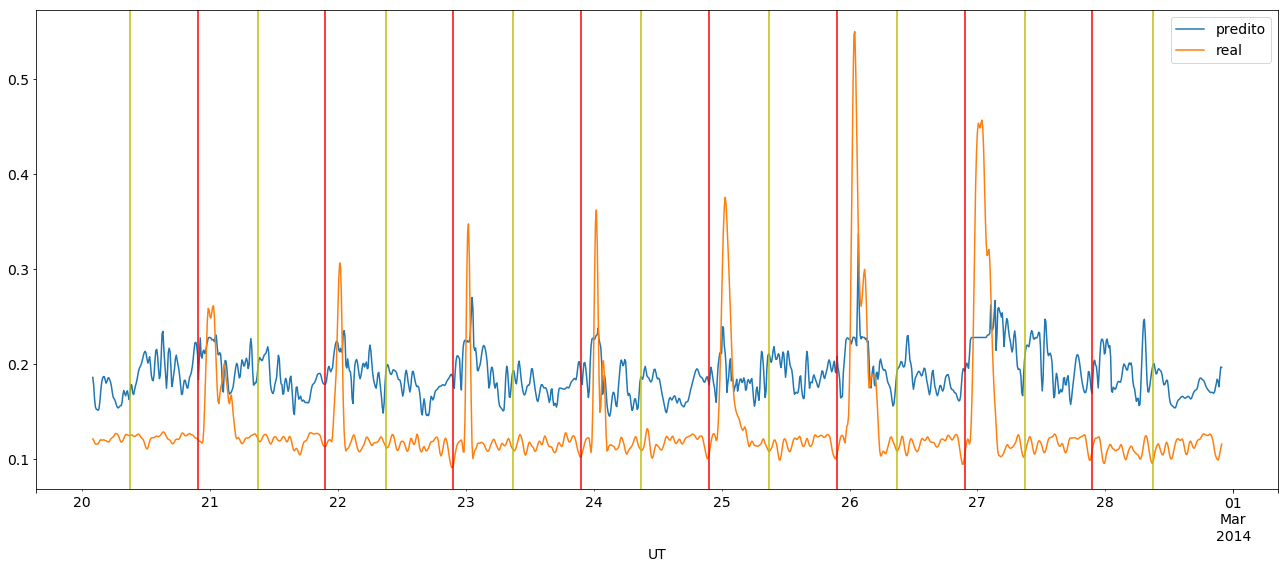

In [5]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4',
                                         file_to_save_model='./images/regression_svm.eps')

## Sem vtec

In [6]:
instances_set = ['vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
acc             0.743082
f1              0.335024
far             0.795312
fn              6.800000
fp            320.000000
kappa           0.019891
me              0.316314
mse             0.005602
pod             0.923596
precission      0.204688
re             52.973990
recall          0.923596
tn            863.000000
tp             82.200000
tse             2.669282
dtype: float64


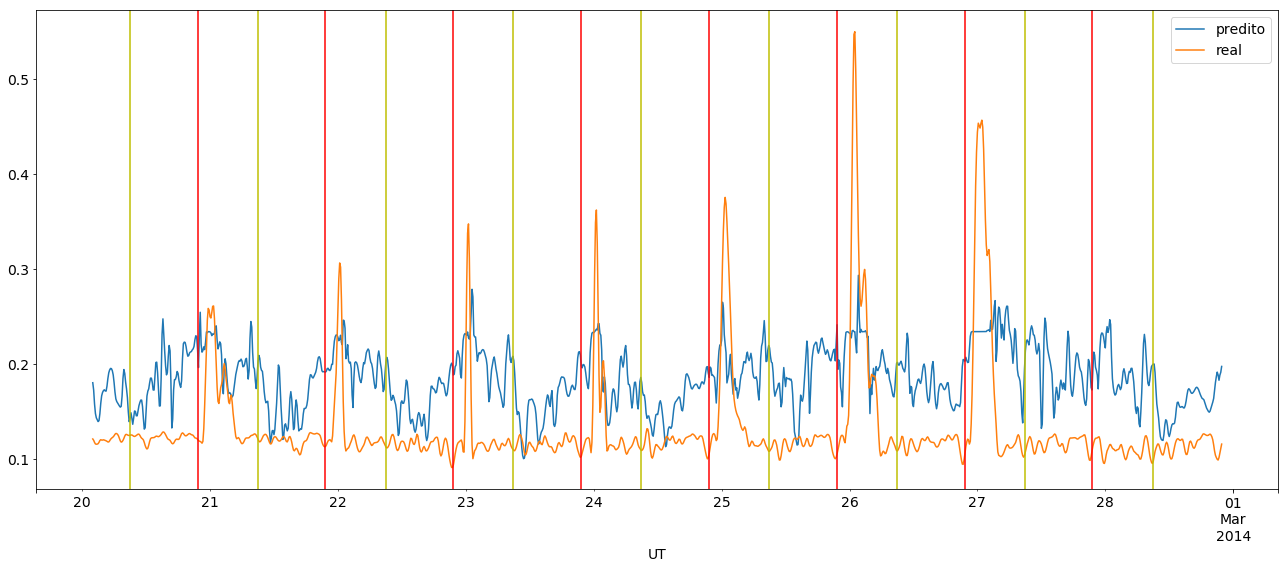

In [7]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal primeira do VTEC

In [8]:
instances_set = ['vtec', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
acc             0.820440
f1              0.424566
far             0.725946
fn              5.000000
fp            223.400000
kappa           0.014560
me              0.319309
mse             0.004893
pod             0.943820
precission      0.274054
re             46.739206
recall          0.943820
tn            959.600000
tp             84.000000
tse             2.493999
dtype: float64


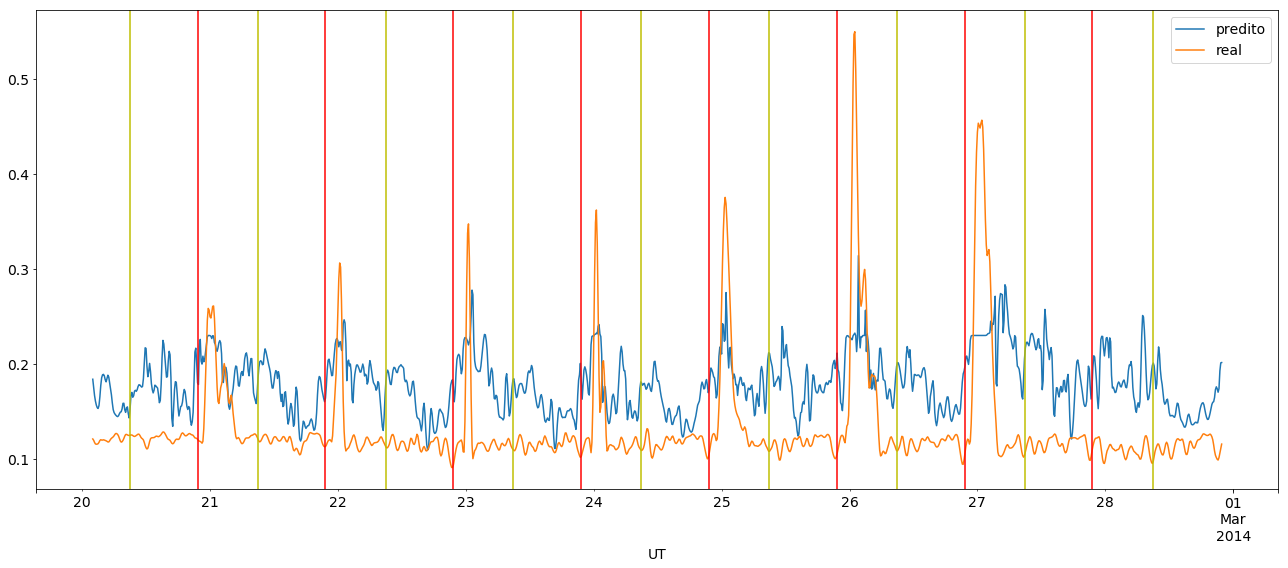

In [9]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal segunda do VTEC

In [10]:
instances_set = ['vtec', 'vtec_dt', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
acc              0.870204
f1               0.446415
far              0.680054
fn              22.700000
fp             142.400000
kappa            0.020487
me               0.331274
mse              0.004413
pod              0.744944
precission       0.319946
re              42.592234
recall           0.744944
tn            1040.600000
tp              66.300000
tse              2.368895
dtype: float64


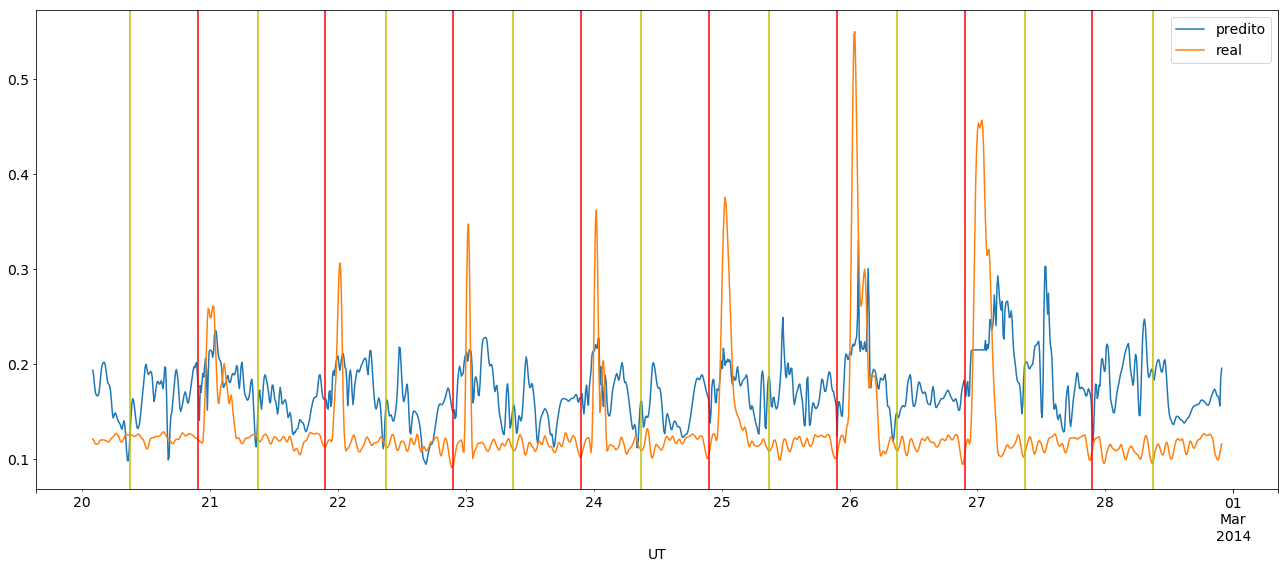

In [11]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem gradiente do VTEC em relação à Pirassununga

In [12]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
acc             0.787814
f1              0.344125
far             0.780315
fn             18.300000
fp            251.600000
kappa           0.021515
me              0.327269
mse             0.005374
pod             0.794382
precission      0.219685
re             50.746367
recall          0.794382
tn            931.400000
tp             70.700000
tse             2.614365
dtype: float64


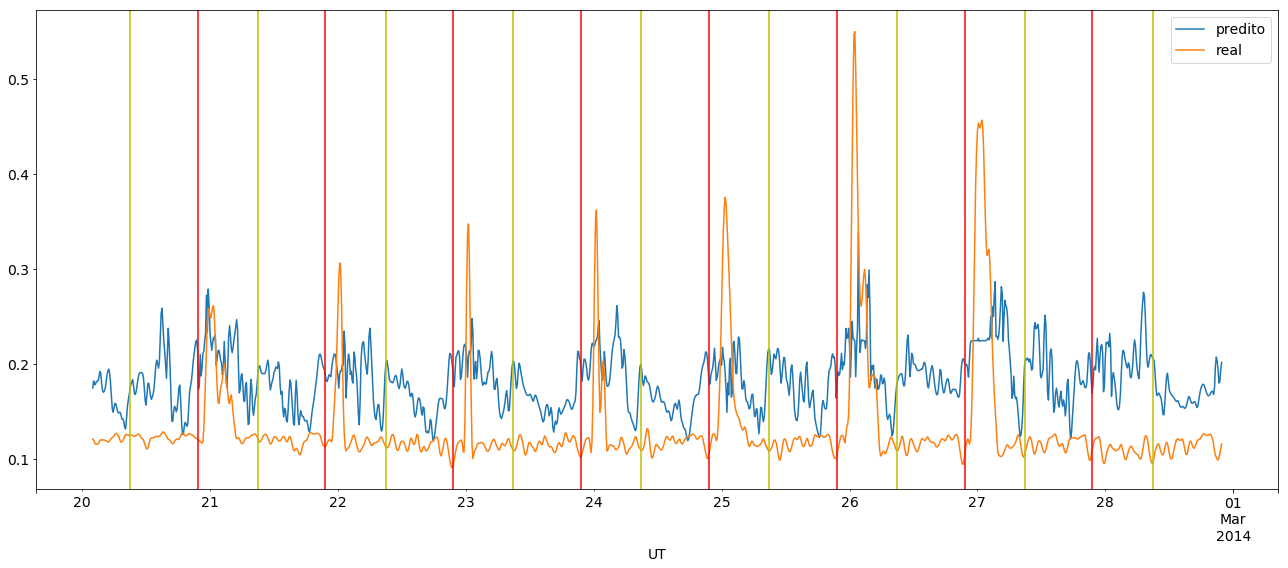

In [13]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal do gradiente do VTEC em relação à Pirassununga

In [14]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec2', 'gvtec2_dt']

Error for the time series sample:
acc              0.843003
f1               0.384191
far              0.735187
fn              26.700000
fp             173.000000
kappa            0.023328
me               0.366103
mse              0.004855
pod              0.700000
precission       0.264813
re              45.742795
recall           0.700000
tn            1010.000000
tp              62.300000
tse              2.484832
dtype: float64


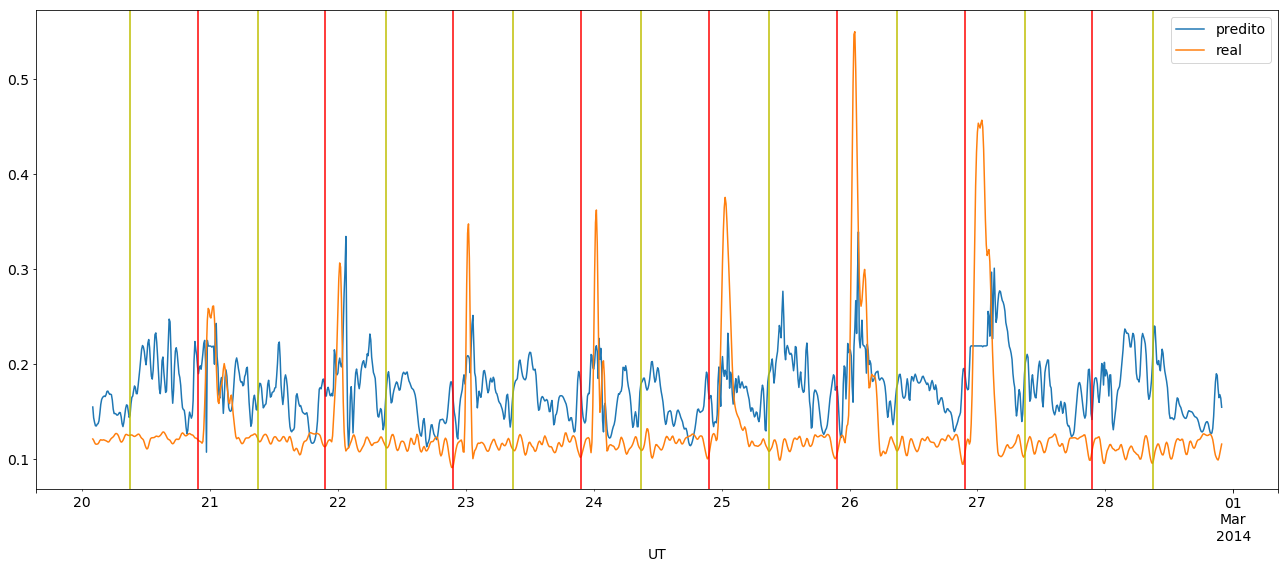

In [15]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem gradiente do VTEC em relação à Brasília

In [16]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2_dt']

Error for the time series sample:
acc             0.762657
f1              0.351044
far             0.782762
fn              7.500000
fp            294.400000
kappa           0.018958
me              0.324985
mse             0.005516
pod             0.915730
precission      0.217238
re             51.130928
recall          0.915730
tn            888.600000
tp             81.500000
tse             2.648611
dtype: float64


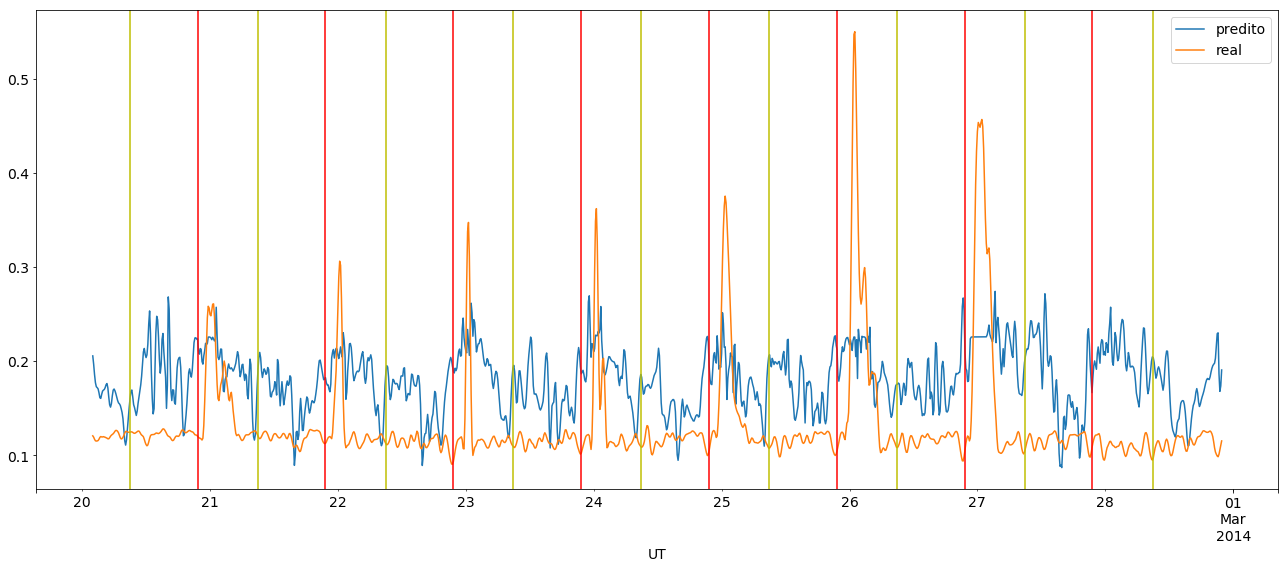

In [17]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')

## Sem derivada temporal do gradiente do VTEC em relação à Brasília

In [18]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2']

Error for the time series sample:
acc             0.828931
f1              0.433808
far             0.717616
fn              5.700000
fp            211.900000
kappa           0.014331
me              0.327253
mse             0.005078
pod             0.935955
precission      0.282384
re             49.297140
recall          0.935955
tn            971.100000
tp             83.300000
tse             2.541061
dtype: float64


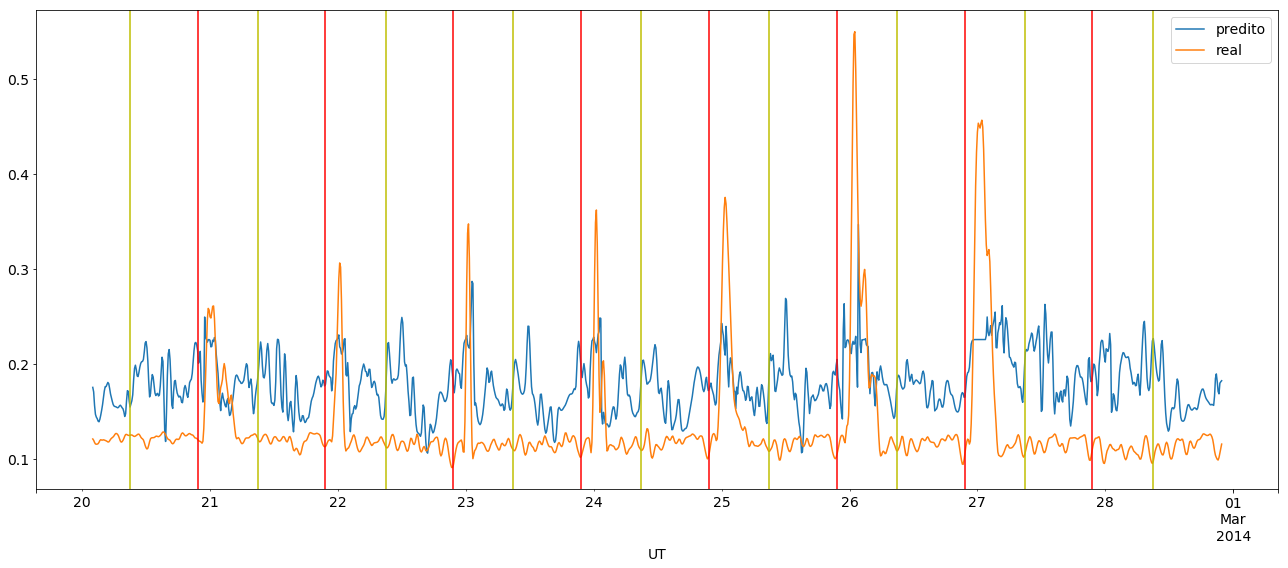

In [19]:
# generate model, use k-fold crossvalidation and print scores
model = SVR
dict_error = generate_and_avaliate_model(model=model,
                                         df=df,
                                         instances_set=instances_set,
                                         target='s4')